In [1]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm
import seaborn as sns

Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)

<module 'LMR_lite_utils' from '/Users/dan/Desktop/LMR_py3/LMR_lite_utils.py'>

In [4]:
# load proxies
lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
cfile = './configs/config.yml.nullspace.'+lmr_names[0]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

prox_manager = LMRlite.load_proxies(cfg)
numprox = len(prox_manager.all_proxies)

Checking configuration ... 
OK!
                                 Bivalve_d18O :     1
               Corals and Sclerosponges_Rates :     8
                Corals and Sclerosponges_SrCa :    25
                Corals and Sclerosponges_d18O :    59
                        Ice Cores_MeltFeature :     1
                               Ice Cores_d18O :    28
                                 Ice Cores_dD :     7
                              Lake Cores_Misc :     2
                             Lake Cores_Varve :     5
                       Tree Rings_WidthPages2 :   347
                       Tree Rings_WoodDensity :    59
                                        TOTAL :   542
-----------------------------------------------------
completed in 3.2419700622558594 seconds
-----------------------------------------------------


In [5]:
# Load and interpolate all of the priors I want to use as truth

lmr_names_t = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ad_t = []

for ii in np.arange(len(lmr_names_t)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names_t[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad_t.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
0 55295
(55296, 100)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887

In [6]:
# Make superpriors from other models

lmr_names_p = ['sp_mpi-esm-p_hadcm3',
               'sp_ccsm4_hadcm3',
               'sp_ccsm4_mpi-esm-p']
model_names_p = ['MPI-ESM+HadCM3','CCSM4+HadCM3','CCSM4+MPI-ESM']
ad_inds = np.array([[1,2],[0,2],[0,1]])

# Initialize 
ad_p = []

for ii in np.arange(len(lmr_names_p)):

    dd = {}

    sp0 = ad_t[ad_inds[ii,0]]['Xbp']
    sp1 = ad_t[ad_inds[ii,1]]['Xbp']
    spa = np.concatenate([sp0,sp1],1)
    
    Xb = spa[:,np.random.choice(200,100,replace=False)]
    Xbp = Xb-Xb.mean(axis=1,keepdims=True)
    
    # grid information is all the same, so borrowing from ad_t[0]
    X = ad_t[0]['X']

    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names_p[ii]
    dd['lmr_name'] = lmr_names_p[ii]
    dd['grid']     = LMRlite.Grid(X)

    print(ii)
    print(dd['name'])

    ad_p.append(dd)
        


0
MPI-ESM+HadCM3
1
CCSM4+HadCM3
2
CCSM4+MPI-ESM


In [7]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]
        if np.any(np.isnan(vYe[proxy_idx,:])):
            print(proxy_idx)
            print(npos)
            print(np.any(np.isnan(Xbp[npos,:])))
            import pdb
            pdb.set_trace()

    return vYe, vYe_coords


In [27]:
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

def process_input(LOCRAD):
    NENS = grid.nens
    SNR = 100.0

    # Initialize array of dictionaries containing the different comparisons
    cdd = []

    # Loop over prior files
    for ii in np.arange(len(lmr_names_p)):

        # Load the config file corresponding to the iith prior
        cfile = './configs/config.yml.nullspace.'+lmr_names_p[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        # Compute effective observations
        vYe, vYe_coords = mk_yes(ad_p[ii]['X'],ad_p[ii]['Xbp'],prox_manager,ad_p[ii]['grid'])

        # change the localization radius in the config file
        cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
        cfg_new = LMR_config.Config(**cfg_params)

        # Just have one truth for each of the superpriors

        jj = ii

        # Use a precomputed interpolated version of the truth
        vY, vR, vP = mk_pproxies(ad_t[jj]['X'],ad_t[jj]['Xbp'],prox_manager,SNR,ad_t[jj]['grid'])

        fp = np.empty([ad_p[ii]['grid'].nlon*ad_p[ii]['grid'].nlat,NENS])

        # Loop over ensemble members
        for kk in np.arange(NENS):
            if LOCRAD==0.:
                f,Xap,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad_p[ii]['Xbp'],verbose=False)
            else:
                f,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad_p[ii]['Xbp'],X=ad_p[ii]['X'],vYe_coords=vYe_coords,verbose=False)

            fp[:,kk] = f

        # Store information in a dictionary for this prior-truth pair
        c = {}
        c['locrad']     = LOCRAD
        c['snr']        = SNR
        c['prior_name'] = ad_p[ii]['name']
        c['truth_name'] = ad_t[jj]['name']
        c['pind']       = ii
        c['tind']       = jj
        c['recon']      = fp
        c['rmse']       = np.mean((ad_t[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
        # for the choices of LOCRAD and SNR
        cdd.append(c)

    # Save all prior-truth pairs for these choices of LOCRAD and SNR
    print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
    np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)


In [28]:
# Run in parallel
# Only need to do this once!
LOCRADs = [0.]#,50000.,35000.,25000.,10000.,5000.,2000.]

from joblib import Parallel, delayed
import multiprocessing
#num_cores = multiprocessing.cpu_count()
nj = len(LOCRADs)
#Parallel(n_jobs=nj)(delayed(process_input)(LOCRADs[i]) for i in np.arange(nj))

Checking configuration ... 
OK!
Checking configuration ... 
OK!
Checking configuration ... 
OK!
saving for LOCRAD = 0.0 and SNR = 100.0


[None]

In [8]:
# Set up the scatter plot

import pandas as pd

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

SNR = '0.4'
#LOCRADs = ['2000.0', '5000.0', '10000.0', '25000.0']
#LOCRADs = ['0.0','50000.0','35000.0','25000.0','10000.0','5000.0','2000.0']
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat = ad_p[0]['grid'].lat

#gm = np.empty([9,len(LOCRADs)])

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    cddsp=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_locrad_' + LOCRAD + '_snr_' + SNR + '.npy')
    cdd  =np.load(   '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + LOCRAD + '_snr_' + SNR + '.npy')

    cdd4 = np.concatenate([cdd,cddsp])
    
    for jj in np.arange(len(cdd4)):
      
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




In [9]:
# Set up the scatter plot

import pandas as pd

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '100.0'
#LOCRADs = ['2000.0', '5000.0', '10000.0', '25000.0']
#LOCRADs = ['0.0','50000.0','35000.0','25000.0','10000.0','5000.0','2000.0']
LOCRADs = ['0.0']
#LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat = ad_p[0]['grid'].lat

#gm = np.empty([9,len(LOCRADs)])

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    cddsp=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_locrad_' + LOCRAD + '_snr_' + SNR + '.npy')
    cdd  =np.load(   '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + LOCRAD + '_snr_' + SNR + '.npy')

    cdd4 = np.concatenate([cdd,cddsp])
    
    for jj in np.arange(len(cdd4)):
      
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse'])/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

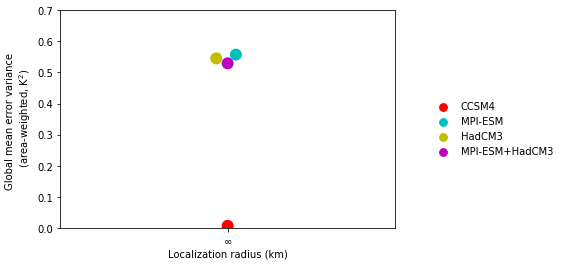

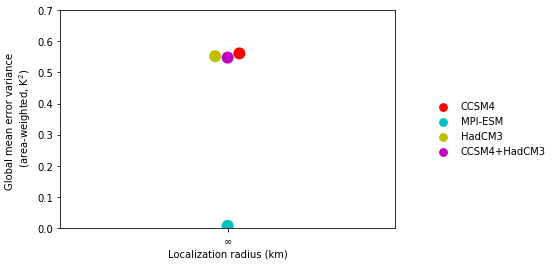

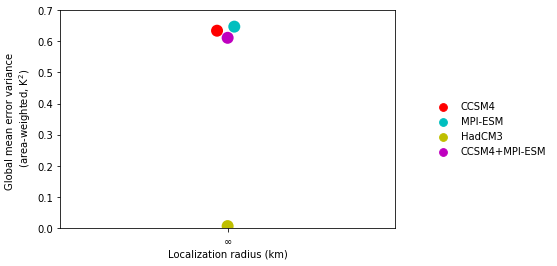

In [10]:
import seaborn as sns

gmp0 = gmp[gmp.truth_name=='CCSM4']
gmp1 = gmp[gmp.truth_name=='MPI-ESM']
gmp2 = gmp[gmp.truth_name=='HadCM3']


si = 12

fig = plt.figure(figsize=(6,4))
ax=sns.swarmplot(data=gmp0,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y", "m"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$'])
plt.xlabel('Localization radius (km)')
plt.ylim([0.,.7])
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.1, .6), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout

fig = plt.figure(figsize=(6,4))
ax=sns.swarmplot(data=gmp1,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y", "m"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$'])
plt.xlabel('Localization radius (km)')
plt.ylim([0.,.7])
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.1, .6), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout

fig = plt.figure(figsize=(6,4))
ax=sns.swarmplot(data=gmp2,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y", "m"])
#plt.xticks(np.arange(len(LOCRADs)),['$\infty$','50000','35000','25000','10000','5000','2000'])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$'])
plt.xlabel('Localization radius (km)')
plt.ylim([0.,.7])
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.1, .6), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout




#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD_sp.pdf')


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

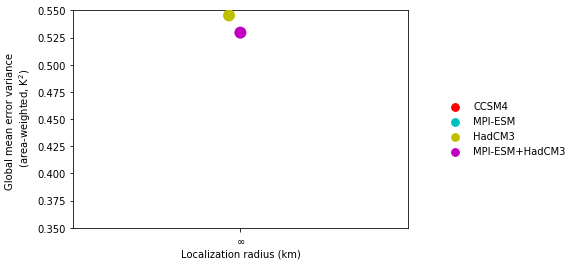

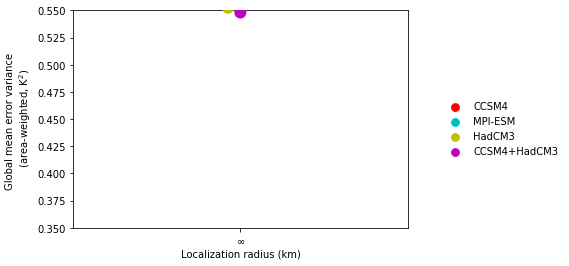

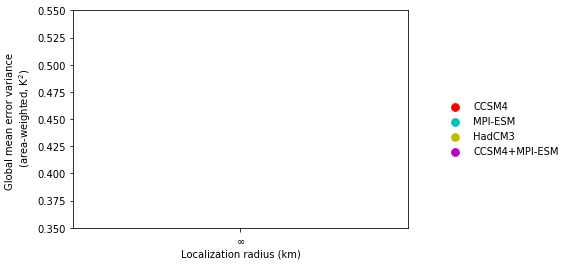

In [11]:
import seaborn as sns

gmp0 = gmp[gmp.truth_name=='CCSM4']
gmp1 = gmp[gmp.truth_name=='MPI-ESM']
gmp2 = gmp[gmp.truth_name=='HadCM3']


si = 12

fig = plt.figure(figsize=(6,4))
ax=sns.swarmplot(data=gmp0,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y", "m"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylim([.35,.55])
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.1, .6), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout

fig = plt.figure(figsize=(6,4))
ax=sns.swarmplot(data=gmp1,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y", "m"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylim([.35,.55])
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.1, .6), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout

fig = plt.figure(figsize=(6,4))
ax=sns.swarmplot(data=gmp2,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y", "m"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylim([.35,.55])
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.1, .6), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout




#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD_sp.pdf')


In [12]:
# Load and interpolate all of the priors I want to use as priors
"""
lmr_names_p = ['sp_mpi-esm-p_hadcm3',
               'sp_ccsm4_hadcm3',
               'sp_ccsm4_mpi-esm-p']
model_names_p = ['MPI-ESM+HadCM3','CCSM4+HadCM3','CCSM4+MPI-ESM']

# Initialize an array of various interpolated model fields
ad_p = []

for ii in np.arange(len(lmr_names_p)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names_p[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names_p[ii]
    dd['lmr_name'] = lmr_names_p[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad_p.append(dd)
"""        


"\nlmr_names_p = ['sp_mpi-esm-p_hadcm3',\n               'sp_ccsm4_hadcm3',\n               'sp_ccsm4_mpi-esm-p']\nmodel_names_p = ['MPI-ESM+HadCM3','CCSM4+HadCM3','CCSM4+MPI-ESM']\n\n# Initialize an array of various interpolated model fields\nad_p = []\n\nfor ii in np.arange(len(lmr_names_p)):\n    dd = {}\n    cfile = './configs/config.yml.nullspace.'+lmr_names_p[ii]\n    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)\n    cfg = LMRlite.load_config(yaml_file)\n    \n    X, Xb_one = LMRlite.load_prior(cfg)\n    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)\n    \n    # check if config is set to regrid the prior\n    if cfg.prior.regrid_method:\n        print('regridding prior...')\n        # this function over-writes X, even if return is given a different name\n        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)\n    else:\n        X.trunc_state_info = X.full_state_info\n    \n    Xb_one = Xb_one_new\n    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)\n 

In [95]:
# Save posterior ensembles for prior-truth pairs

SNR = 0.4
LOCRADs = [5000., 25000., 10000., 0.]
NENS = grid.nens

ad = ad_p

for hh in np.arange(len(LOCRADs)):

    LOCRAD = LOCRADs[hh]
    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')

    # Loop over prior files
    count = 0
    for ii in np.arange(len(lmr_names_p)):

        # Load the config file corresponding to the iith prior
        cfile = './configs/config.yml.nullspace.'+lmr_names_p[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        # Compute effective observations
        vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

        # change the localization radius in the config file
        cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
        cfg_new = LMR_config.Config(**cfg_params)

        # Loop over truth files. Just have one truth for each superprior.
        jj = ii
        print(count)

        # Use a precomputed interpolated version of the truth
        vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

        fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

        # Loop over ensemble members in truth. f are the reconstructions.
         # Grab an Xa. It's the same for all reconstructions!
        if LOCRAD==0.:
            _,Xa,_ = LMRlite.Kalman_optimal(vY[:,0],vR,vYe,ad[ii]['Xbp'],verbose=False)
        else:
            _,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,0],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

        # Store information in a dictionary for this prior-truth pair
        cdd[count]['Xa']       = Xa
        cdd[count]['double-check PT']=ad[ii]['name']+ad[jj]['name']
        count = count+1

    # Save all prior-truth pairs for these choices of LOCRAD and SNR
    print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
    np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_Xa_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
print('Done!')        

Checking configuration ... 
OK!
0
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)


/Users/dan/Desktop/LMR_py3/LMR_utils.py:89: RuntimeWarning: invalid value encountered in arcsin
  c = 2 * np.arcsin(np.sqrt(a))
/Users/dan/Desktop/LMR_py3/LMR_DA.py:157: RuntimeWarning: invalid value encountered in less_equal
  ind_inner = np.where(dists <= hlr)    # closest
/Users/dan/Desktop/LMR_py3/LMR_DA.py:158: RuntimeWarning: invalid value encountered in greater
  ind_outer = np.where(dists >  hlr)    # close
/Users/dan/Desktop/LMR_py3/LMR_DA.py:159: RuntimeWarning: invalid value encountered in greater
  ind_out   = np.where(dists >  2.*hlr) # out


Checking configuration ... 
OK!
1
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
2
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
saving for LOCRAD = 5000.0 and SNR = 0.4
Checking configuration ... 
OK!
0
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
1
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
2
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
saving for LOCRAD = 25000.0 and SNR = 0.4
Checking configuration ... 
OK!
0
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
1
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
2
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
saving for LO

In [85]:
def KLdiv(X0,X1):
    # X1 is one ensemble (assumed multivariate Gaussian); X2 is another
    # See https://en.wikipedia.org/wiki/Kullback–Leibler_divergence
    #{\displaystyle D_{\text{KL}}({\mathcal {N}}_{0}\parallel {\mathcal {N}}_{1})={\frac {1}{2}}\left(\operatorname {tr} \left(\Sigma _{1}^{-1}\Sigma _{0}\right)+(\mu _{1}-\mu _{0})^{\mathsf {T}}\Sigma _{1}^{-1}(\mu _{1}-\mu _{0})-k+\ln \left({\frac {\det \Sigma _{1}}{\det \Sigma _{0}}}\right)\right).}
    # Computed using pseudoinverses so that we don't every have to store full covariances in memory.
    
    [k,N0] = X0.shape
    [k,N1] = X1.shape

    X0m = np.mean(X0,1)
    X1m = np.mean(X1,1)

    X0p = X0 - X0.mean(axis = 1,keepdims=True)
    X1p = X1 - X1.mean(axis = 1,keepdims=True)
    
    fac = (1/(N0-1))
    
    [u0, s0, v0] = np.linalg.svd(X0p,full_matrices=False)
    [u1, s1, v1] = np.linalg.svd(X1p,full_matrices=False)
    
    if (np.linalg.matrix_rank(X0)<len(s0)) | (np.linalg.matrix_rank(X1)<len(s1)):
        raise ValueError('Rank deficient covariances.')

    s02 = fac*s0**2
    s12 = fac*s1**2
    s12i = s1**-2/fac

    # I sum over the Hadamard product (*u0) to compute the trace.

    D = 1/2*(np.sum( (  u1.dot(np.diag(s12i)).dot(u1.T.dot(u0)).dot(np.diag(s02))  ) * u0 )
            + ((X0m-X1m).dot(u1).dot(np.diag(s12i))).dot((u1.T).dot(X0m-X1m))
            - k
            + np.log(np.prod(s12/s02))
            )

    return D
    

In [86]:
def regJSdiv(X0,X1,alpha):

    [k,N0] = X0.shape
    [k,N1] = X1.shape

    if (N0!=N1):
        raise ValueError('Sample size must be the same for now!')

    X = np.concatenate([X0,X1],1)
    [u0, s, vh0] = np.linalg.svd(X0,full_matrices=False)
    [u1, s, vh0] = np.linalg.svd(X1,full_matrices=False)

    X0r = X0-u1.dot(u1.T.dot(X0))
    X1r = X1-u0.dot(u0.T.dot(X1))

    # Can confirm that these two forms are the same, so we can go ahead with feeding LH factors to KLdiv
    #f1 = X0.dot(X0.T)+alpha*X1r.dot(X1r.T)
    #Xa = np.concatenate([X0,np.sqrt(alpha)*X1r])
    #f2 = Xa.dot(Xa.T)
    #f1 - f2

    Xa0 = np.concatenate([X0,np.sqrt(alpha)*X1r],1)
    Xa1 = np.concatenate([X1,np.sqrt(alpha)*X0r],1)
    Xa = np.concatenate([X0,X1],1)

    # Project onto the left leading 2*N0-1 SVs of X to make sure cov matrices are full rank
    trunc = np.min([np.linalg.matrix_rank(Xa),np.linalg.matrix_rank(Xa1),np.linalg.matrix_rank(Xa0)])-1
    [u,s,vh] = np.linalg.svd(Xa,full_matrices=False)
#    X0u = u[:,:2*N0-1].T.dot(Xa0)
    X0u = u[:,:trunc].T.dot(Xa0)
    X1u = u[:,:trunc].T.dot(Xa1)
    Xu  = u[:,:trunc].T.dot(Xa)

#    X0u = (Xa0)
#    X1u = (Xa1)
#    Xu  = (Xa)

    D = (1/2)*(KLdiv(X0u,Xu)+KLdiv(X1u,Xu))

    return D

In [99]:
# Actually implementing J-S

LOCRAD = 25000.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_Xa_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')

for ind in (np.arange(3)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    truth = ad[cdd[ind]['tind']]['Xbp']
    recon = cdd[ind]['recon']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])
    d = truth-recon
    
    print(regJSdiv(d,Xap,1.))

LOCRAD = 0.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_Xa_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')

for ind in (np.arange(3)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    truth = ad[cdd[ind]['tind']]['Xbp']
    recon = cdd[ind]['recon']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])
    d = truth-recon
    
    print(regJSdiv(d,Xap,1.))


MPI-ESM+HadCM3MPI-ESM+HadCM3
63.12032303445379
CCSM4+HadCM3CCSM4+HadCM3
66.08333495944238
CCSM4+MPI-ESMCCSM4+MPI-ESM
65.22277653789808
MPI-ESM+HadCM3MPI-ESM+HadCM3
42.47900096106726
CCSM4+HadCM3CCSM4+HadCM3
42.336883224980134
CCSM4+MPI-ESMCCSM4+MPI-ESM
43.08001622567286


In [106]:
# Now trying something simple: Looking at the area-weighted trace of Pa for the superpriors

LOCRAD = 0.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_sp_Xa_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')

for ind in (np.arange(3)):
    print(cdd[ind]['double-check PT'])
    Xa   = cdd[ind]['Xa']
    rmse = cdd[ind]['rmse']
    pad = np.var(Xa,1)
    gm0 = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd[ind]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
    gm1 = np.sum(np.cos(np.deg2rad(lat.ravel()))*pad)/np.sum(np.cos(np.deg2rad(lat)))
    
    print(gm0)
    print(gm1)




MPI-ESM+HadCM3MPI-ESM+HadCM3
0.3385807716283677
0.21712743585165706
CCSM4+HadCM3CCSM4+HadCM3
0.3104899192975479
0.21173476540753178
CCSM4+MPI-ESMCCSM4+MPI-ESM
0.3570875265199879
0.20601748350327162


In [ ]:
# What is going on? It appears that making the superprior doesn't actually
# increase the DOF! Surprising... do we need more ensemble members?